# script for generating synthetic longitudinal progressions

In [ ]:
using DifferentialEquations, SciMLBase, Plots, Random, DataStructures, DelimitedFiles, XLSX
using LatinHypercubeSampling
using JLD2
using Dates
using Trapz

include("./EDES/including.jl")
include("./DataGeneration/AnalyseSynths/SyntheticPatients.jl")
include("./DataGeneration/DiseaseProgression/DiseaseProgression.jl")
include("./DataGeneration/AnalyseSynths/LocalSensitivity.jl")
include("./DataGeneration/AnalyseSynths/Realism_inital.jl")
include("./DataGeneration/AnalyseSynths/Realism_progression_diabetic.jl")

# Set the seed for reproducibility
Random.seed!(1234)

In [86]:
n = 100
parameters = ["k5","k6"]
BW = 70

means_params = [0.0424, 2.2975]#0.0174,#4.6237]


lower_deviation = means_params .- (means_params .*0.1)
higher_deviation = means_params .+ (means_params .* 0.1)


# deviation_NutriTech = std_NutriTech ./ means_NutriTech

# lower_deviation = means_NutriTech .- (means_NutriTech .* deviation_NutriTech*0.1)
# higher_deviation = means_NutriTech .+ (means_NutriTech .* deviation_NutriTech*0.1)

parameter_ranges = OrderedDict( "k5" => (lower_deviation[1], higher_deviation[1]), 
                    "k6" => (lower_deviation[2], higher_deviation[2]))
fasting_ranges = OrderedDict("fasting_glucose" => (4.8,5.2), 
                        "fasting_insulin" => (7.5, 12),)
Synthetic_population = MakePatients(n, parameters, parameter_ranges, fasting_ranges, BW = BW)

true

Ensure realism in the model outputs from the synthetic patients' first test moment 

In [87]:
boolean_vector = []
for i in 1:length(Synthetic_population)
    synthetic_patient = Synthetic_population[i]
    result = ensure_realism_initial(synthetic_patient)
    push!(boolean_vector, result)
end


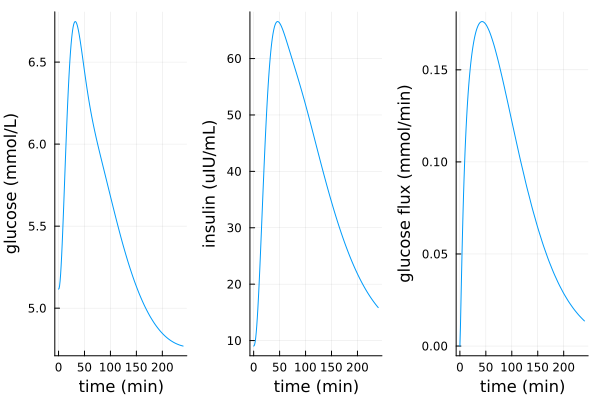

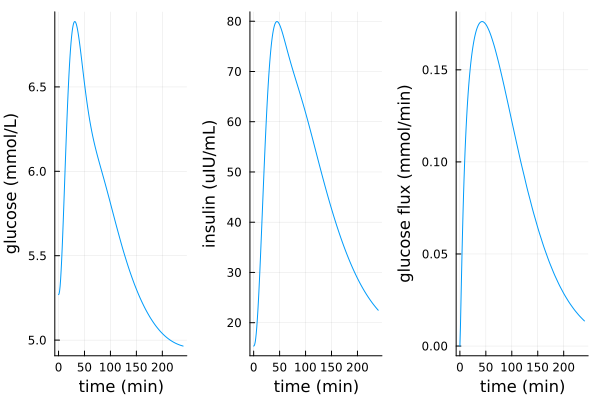

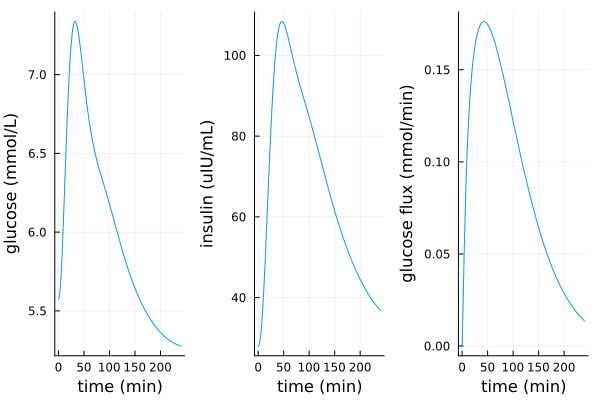

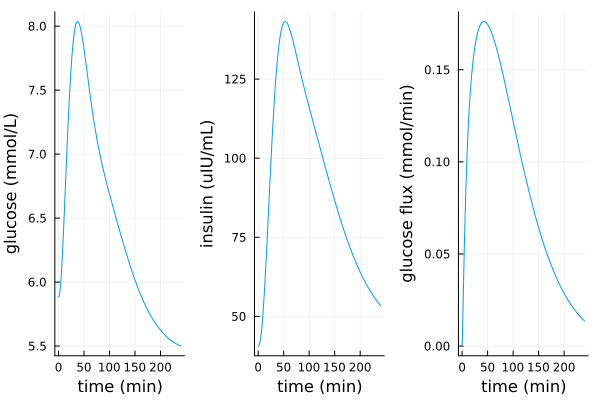

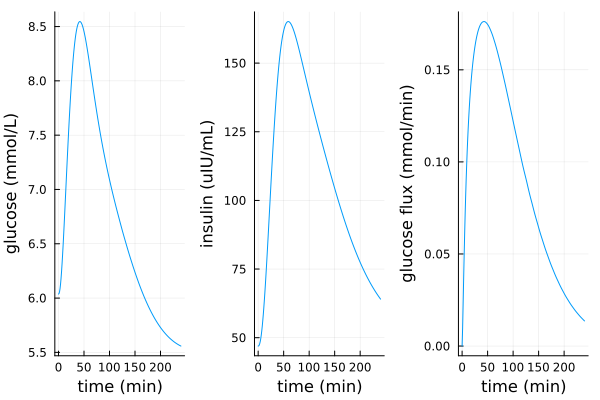

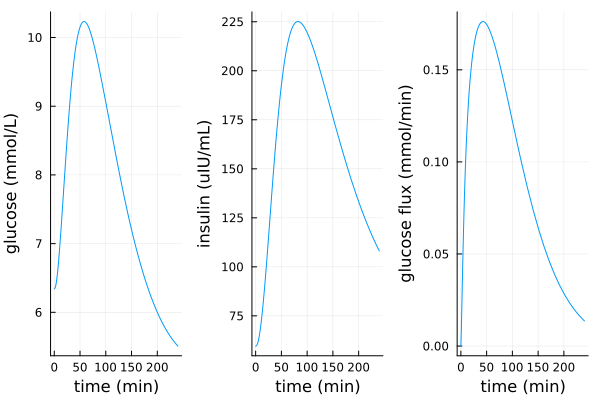

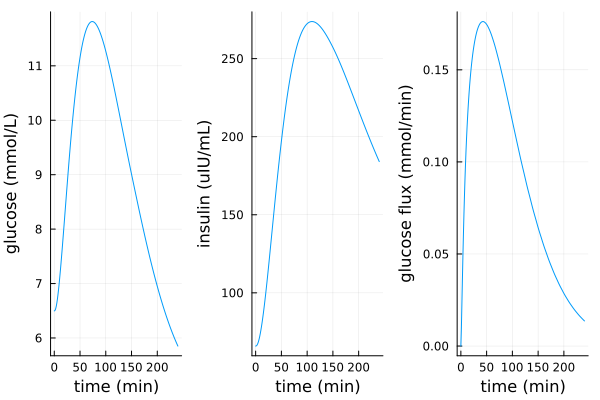

In [79]:
include("./EDES/including.jl")

k5_linear = 0.1
k6_parabolic = 0.02
k6_linear = 0.15
long_time_points = [0,1,3,5,6,8,9]
glucose_time_points = [0,15,30,60,120,180,240]
insulin_time_points = [0,15,30,60,120,240]

# initialise output
outputs_glc = zeros(length(long_time_points), length(glucose_time_points), length(Synthetic_population))
outputs_ins = zeros(length(long_time_points), length(insulin_time_points), length(Synthetic_population))

IDs = zeros(length(Synthetic_population),length(long_time_points))
Health = zeros(length(Synthetic_population))

# loop over the patients
for i in 1:length(Synthetic_population)
    # select the patient
    synthetic_patient = Synthetic_population[i]
    IDs[i,:] .= synthetic_patient.ID
    
    # set a boolean for the health status, even patients are healthy, odd patients are diabetic
    if i % 2 == 0
        Health_bool = true
    else
        Health_bool = false
    end

    Health[i] = Health_bool

    # change the k5 and k6 values
    k5s,k6s, Gbs, I_pl_bs = DiabeticProgression(long_time_points, synthetic_patient,k5_linear,k6_parabolic, k6_linear, Health_bool)

    for j in 1:length(long_time_points)
        # copy the parameter values and the model_copy
        parameter_values_copy = copy(synthetic_patient.ParameterValues)
        model_copy = deepcopy(synthetic_patient.EDES)
        # change the k5 and k6 values
        parameter_values_copy[1] = k5s[j]
        parameter_values_copy[2] = k6s[j]

        # add Gb value
        push!(parameter_values_copy, Gbs[j])
        push!(parameter_values_copy, I_pl_bs[j])
        
        # reassign the names of the parameters to set values for
        model_copy.estimated_params = ["k5","k6","G_b","I_pl_b"]

        # reset the fasting glucose as the actual basal glucose
        model_copy.prob.u0[2] = Gbs[j]
        model_copy.prob.u0[4] = I_pl_bs[j]   

        # plot the meal response
        if i == 1
            plt = PlotMealResponse(model_copy, parameter_values_copy);
            display(plt)
            #savefig("../Images/SyntheticPatientResponses/SyntheticPatient$i-$j-k5-$k5_linear-k6-$k6_parabolic-k6-$k6_linear.png")
        end
        if j ==7 && i == 1
            LocalSensitivityAnalysis(model_copy, parameter_values_copy, spread = 0.5)
        end

        glc, ins= SelectTimePoints(model_copy,parameter_values_copy, glucose_time_points, insulin_time_points)

        outputs_glc[j,:,i] = glc
        outputs_ins[j,:,i] = ins

        # ensure realism of the outputs
        ensure_realism_initial(model_copy, parameter_values_copy)

    end
end

# #save the outputs
# date_str = Dates.format(now(), "yyyy-mm-dd")
# time_str = Dates.format(now(), "HH_MM")
# date_time_str = date_str * "-" * time_str
# file_name = "./Results/SyntheticPatientsOutputs_$date_time_str.jld2"

# save(file_name, 
#     "glucose", outputs_glc, 
#     "insulin", outputs_ins, 
#     "time_G", glucose_time_points,
#     "time_I", insulin_time_points,
#     "BW", BW,
#     "ID", IDs,
#     "Health", Health,
#     "k5_linear", k5_linear,
#     "k6_parabolic", k6_parabolic,
#     "k6_linear", k6_linear,

# )

# logs
#writedlm("../Images/Logs/SyntheticPatients_$k5_linear,_$k6_parabolic,.txt", [k5s,k6s,k5_linear,k6_parabolic,k6_linear]

In [83]:

first_person_glucose = outputs_glc[:,:,1]
first_person_insulin = outputs_ins[:,:,1]

ensure_realism_diabetic(first_person_glucose, first_person_insulin, long_time_points)

Glucose peak must be higher every measurement


false

In [84]:
maximum(first_person_insulin, dims=2)
first_person_glucose

7×7 Matrix{Float64}:
 5.14728  6.08842  6.77904   6.27567   5.46782  4.96084  4.79815
 5.07136  5.97689  6.62502   6.06684   5.37143  4.92498  4.77819
 5.37176  6.30208  7.05356   6.4635    5.72505  5.24742  5.08292
 5.91135  6.91986  7.95634   7.55726   6.43057  5.77027  5.5261
 6.26602  7.33089  8.58059   8.49443   6.9661   6.11126  5.76923
 6.55984  7.66897  9.33228  10.5752    8.55317  6.61303  5.69662
 6.74073  7.87693  9.75563  12.0404   10.8101   7.9894   6.07076